In [10]:
import pandas as pd 
import io
import math
from tqdm import tqdm
import multiprocess as mp 
import dask.dataframe as dd
import requests

centroid_stops = [82,192]

endpoints_by_yr = [
    'https://data.ny.gov/resource/rapa-97zv.csv', 
    'https://data.ny.gov/resource/nqnz-e9z9.csv', 
    'https://data.ny.gov/resource/uhf3-t34z.csv',
    'https://data.ny.gov/resource/jsu2-fbtj.csv',
    'https://data.ny.gov/resource/y2qv-fytt.csv'
]

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of Earth in kilometers
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    return distance

def compute_yearly(endpoint, demand_stations, origin_station_id=['82','192']):

    #retrieve request
    def build_tbl(endpoint, payload):
        try:
            r = requests.get(
                url = endpoint, params = payload
            ) 
            return pd.read_csv(io.StringIO(r.text))
        except Exception:
            print(r.status_code) 
            print(r.reason) 
            return pd.DataFrame() 
            
    stations_str = ','.join(origin_station_id) if type(origin_station_id) != str else origin_station_id
    demand_stations_str = ','.join(demand_stations) if type(demand_stations) != str else demand_stations
    
    #retrieve inbound/outbound ridership, across whole system and within qns
    payloads = [
        {
            '$select':'timestamp,SUM(estimated_average_ridership) as outbound_ridership',
            '$where':f"origin_station_complex_id in ({stations_str})",
            '$group':'timestamp',
            '$order':'timestamp',
            '$limit':50000
        }, 
        {
            '$select':'timestamp,SUM(estimated_average_ridership) as inbound_ridership',
            '$where':f"destination_station_complex_id in ({stations_str})",
            '$group':'timestamp',
            '$order':'timestamp',
            '$limit':50000
        }, 
        {
            '$select':'timestamp,SUM(estimated_average_ridership) as outbound_ridership_qns_only',
            '$where':f"origin_station_complex_id in ({stations_str}) and destination_station_complex_id in ({demand_stations_str})",
            '$group':'timestamp',
            '$order':'timestamp',
            '$limit':50000
        }, 
        {
            '$select':'timestamp,SUM(estimated_average_ridership) as inbound_ridership_qns_only',
            '$where':f"destination_station_complex_id in ({stations_str}) and origin_station_complex_id in ({demand_stations_str})",
            '$group':'timestamp',
            '$order':'timestamp',
            '$limit':50000
        }
        
    ]

    #use the multicore to speed things up
    pool = mp.Pool(processes=4)
    mapped = pool.map(lambda x: build_tbl(endpoint = endpoint, payload = x), payloads)

    return mapped

def generate_ridership_data(csv_name, demand_stations, study_area):
    ttl_added_coverage=[]
    for idx,en in tqdm(enumerate(endpoints_by_yr)):
        print(f'*** LOADING 202{idx+1} SUBWAY RIDERSHIP DEMAND TS DATA ***') 
    
        ttl_added_coverage.append(
            compute_yearly(
                endpoint = en, 
                demand_stations = demand_stations,
                origin_station_id = study_area.astype(str)
            )
        )

    ttl_r_2 = pd.concat([pd.concat([i.set_index('timestamp') for i in j],axis=1) for j in ttl_added_coverage],axis=0)
    if csv_name: 
        ttl_r_2.to_csv(f'datasets/outputs/{csv_name}.csv')

    return ttl_r_2

station_metadata=pd.read_csv('datasets/MTA_Subway_Entrances_and_Exits__2024_20250417.csv')

#find qns stations along the qns blvd line, the roosevelt ave line (7), and the astoria line (N,W)
#basically anywhere in queens easily served by qnslink
qns_stations = station_metadata.loc[
    (station_metadata['Borough']=='Q')
   &(~station_metadata['Daytime Routes'].str.contains('A|C|J|Z'))
]
qns_stations_tr = qns_stations[['Stop Name','Complex ID','Daytime Routes']].drop_duplicates()
qns_stations_lst = ','.join(qns_stations['Complex ID'].unique().astype(str))

#find manh stations that are likely to be reached more easily via qnslink 
#use the flatiron building as the spatial threshold 
flatiron_bldg = [40.7412928,-73.9900236]

manh_stations = station_metadata.loc[
    (station_metadata['Borough']=='M')
   &(station_metadata['Entrance Latitude'] > flatiron_bldg[0])
]
manh_stations_tr = manh_stations[['Stop Name','Complex ID','Daytime Routes']].drop_duplicates()
manh_stations_lst = ','.join(manh_stations['Complex ID'].unique().astype(str))
all_stations_lst = f'{qns_stations_lst},{manh_stations_lst}'

#find infill stations near qnslink transfer points, set radius 
lat_lon = station_metadata\
            .groupby(['Complex ID'])[[
                'Entrance Latitude',
                'Entrance Longitude'
                ]]\
            .mean() \
            .reset_index()

centroids = lat_lon.loc[lat_lon['Complex ID'].isin(centroid_stops)]

for i,r in centroids.iterrows(): 
    ref_lat, ref_lon = r['Entrance Latitude'],r['Entrance Longitude'] 
    lat_lon[f"distance_{r['Complex ID']}"] = \
    lat_lon.apply(lambda r: haversine(ref_lat,ref_lon,r['Entrance Latitude'],r['Entrance Longitude']),axis=1)
    

max_radius = 2 

study_area = lat_lon.loc[
    (lat_lon['distance_82.0'] < max_radius)
   &(lat_lon['distance_192.0'] < max_radius)
]['Complex ID'].unique() 

#build dataset, compile records from 2021-2025
#generate_ridership_data('subway_travel_demand', qns_stations_lst, study_area)
#generate_ridership_data('subway_travel_demand3', all_stations_lst, study_area)

In [12]:
import matplotlib.pyplot as plt 
import numpy as np

subway_data = pd.read_csv('datasets/outputs/subway_travel_demand2.csv')
subway_data_w_manh =  pd.read_csv('datasets/outputs/subway_travel_demand3.csv')
subway_data_w_manh = subway_data_w_manh.rename(columns={
    'outbound_ridership_qns_only':'outbound_ridership_qns_manh', 
    'inbound_ridership_qns_only':'inbound_ridership_qns_manh'
}).drop(columns=['outbound_ridership','inbound_ridership'])

combined_subway_ridership = subway_data.merge(
    subway_data_w_manh, 
    how='inner', 
    on=['timestamp']
)

combined_subway_ridership['ttl_qns_manh'] = combined_subway_ridership['outbound_ridership_qns_manh']+combined_subway_ridership['inbound_ridership_qns_manh']
combined_subway_ridership['ttl_qns_only'] = combined_subway_ridership['outbound_ridership_qns_only']+combined_subway_ridership['inbound_ridership_qns_only']
combined_subway_ridership['ttl_systemwide'] = combined_subway_ridership['outbound_ridership']+combined_subway_ridership['inbound_ridership']
combined_subway_ridership['timestamp'] = pd.to_datetime(combined_subway_ridership['timestamp'])

#combined_subway_ridership = combined_subway_ridership.set_index('timestamp')

combined_subway_ridership.head(10)

,timestamp,outbound_ridership,inbound_ridership,outbound_ridership_qns_only,inbound_ridership_qns_only,outbound_ridership_qns_manh,inbound_ridership_qns_manh,ttl_qns_manh,ttl_qns_only,ttl_systemwide
0,2021-01-04 00:00:00,25.4997,66.3541,2.0500,2.6916,3.8918,15.9457,19.8375,4.7416,91.8538
1,2021-01-04 04:00:00,184.5029,30.4035,2.4120,1.2133,90.2421,7.7584,98.0005,3.6253,214.9064
2,2021-01-04 05:00:00,1264.5641,195.2186,71.8698,17.6437,522.7443,34.3611,557.1054,89.5135,1459.7827
3,2021-01-04 06:00:00,1878.1346,365.2349,94.1308,39.1994,720.3613,81.7553,802.1166,133.3302,2243.3695
4,2021-01-04 07:00:00,2123.6346,451.7727,117.7818,41.7635,756.0108,114.2749,870.2857,159.5453,2575.4073
5,2021-01-04 08:00:00,1532.9656,473.3121,93.4752,46.3884,504.9597,114.3456,619.3053,139.8636,2006.2777
6,2021-01-04 09:00:00,887.1966,347.7784,66.5791,39.7408,299.4639,84.2137,383.6776,106.3199,1234.9750
7,2021-01-04 10:00:00,610.5773,316.5417,53.5521,35.6549,203.6691,87.9631,291.6322,89.2070,927.1190
8,2021-01-04 11:00:00,516.6404,350.9225,48.7341,50.8378,168.8415,117.7460,286.5875,99.5719,867.5629
9,2021-01-04 12:00:00,556.8035,473.0202,61.4084,57.8929,189.4698,155.0519,344.5217,119.3013,1029.8237


In [15]:
combined_subway_ridership

,timestamp,outbound_ridership,inbound_ridership,outbound_ridership_qns_only,inbound_ridership_qns_only,outbound_ridership_qns_manh,inbound_ridership_qns_manh,ttl_qns_manh,ttl_qns_only,ttl_systemwide
0,2021-01-04 00:00:00,25.4997,66.3541,2.0500,2.6916,3.8918,15.9457,19.8375,4.7416,91.8538
1,2021-01-04 04:00:00,184.5029,30.4035,2.4120,1.2133,90.2421,7.7584,98.0005,3.6253,214.9064
2,2021-01-04 05:00:00,1264.5641,195.2186,71.8698,17.6437,522.7443,34.3611,557.1054,89.5135,1459.7827
3,2021-01-04 06:00:00,1878.1346,365.2349,94.1308,39.1994,720.3613,81.7553,802.1166,133.3302,2243.3695
4,2021-01-04 07:00:00,2123.6346,451.7727,117.7818,41.7635,756.0108,114.2749,870.2857,159.5453,2575.4073
...,...,...,...,...,...,...,...,...,...,...
8369,2025-02-09 19:00:00,252.7582,602.3699,29.8537,72.2658,67.2693,210.8428,278.1121,102.1195,855.1281
8370,2025-02-09 20:00:00,249.8699,493.9573,22.2782,70.1607,64.6266,192.8162,257.4428,92.4389,743.8272
8371,2025-02-09 21:00:00,202.5014,383.1571,14.6041,48.5416,61.3992,154.7637,216.1629,63.1457,585.6585
8372,2025-02-09 22:00:00,171.0082,386.3415,16.4339,42.3235,39.4066,156.3409,195.7475,58.7574,557.3497


##### Analysis

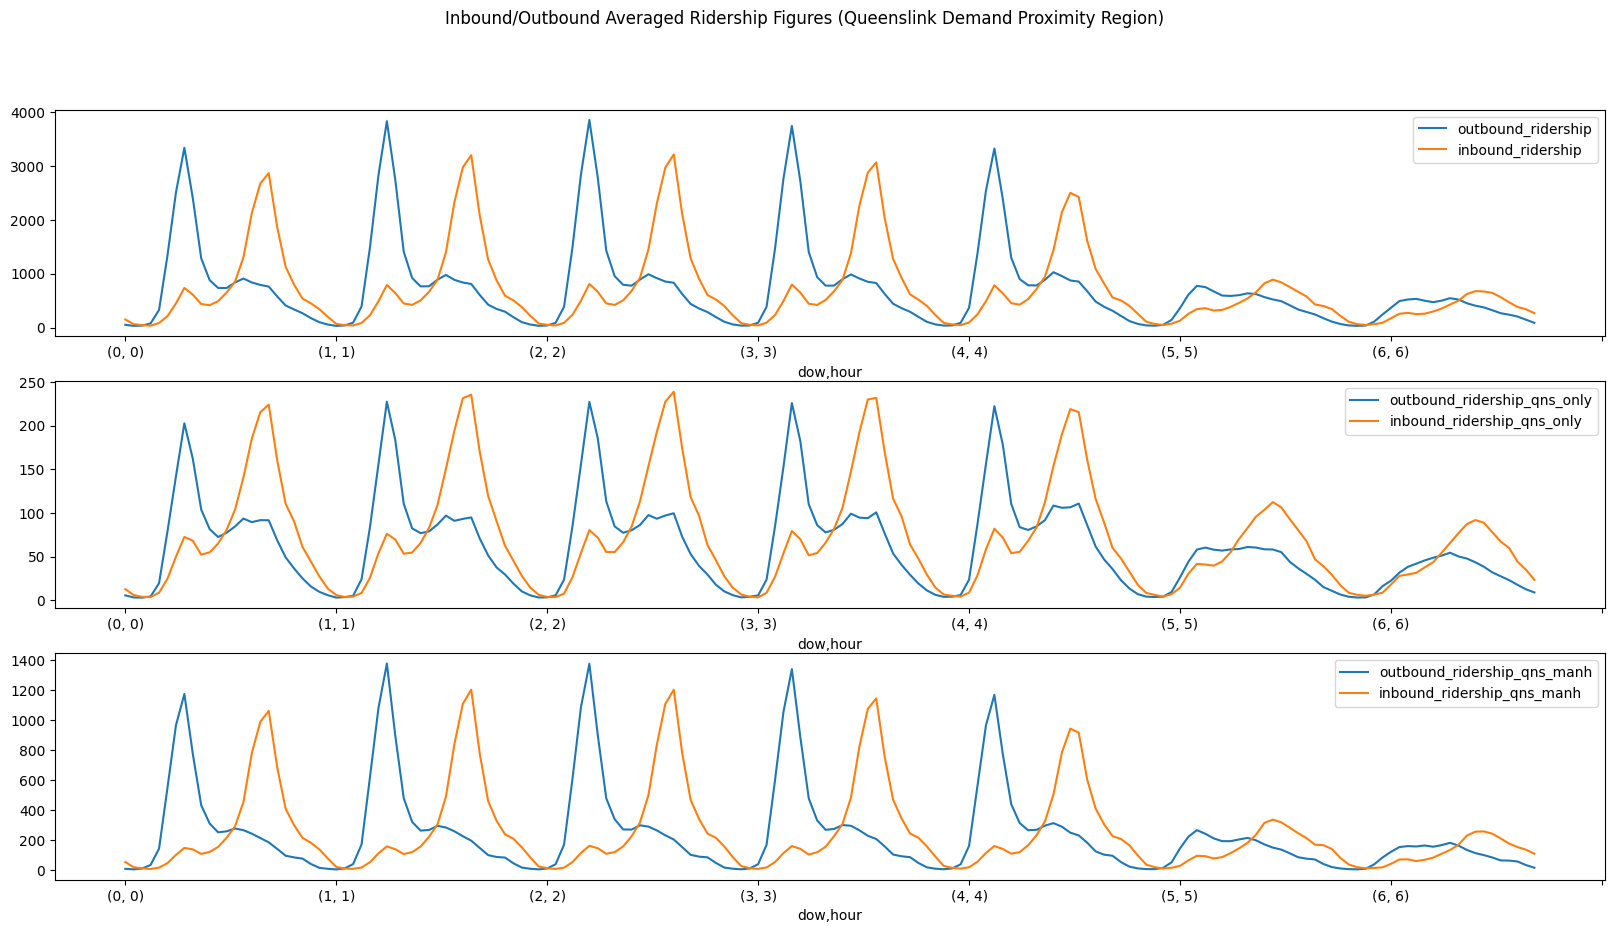

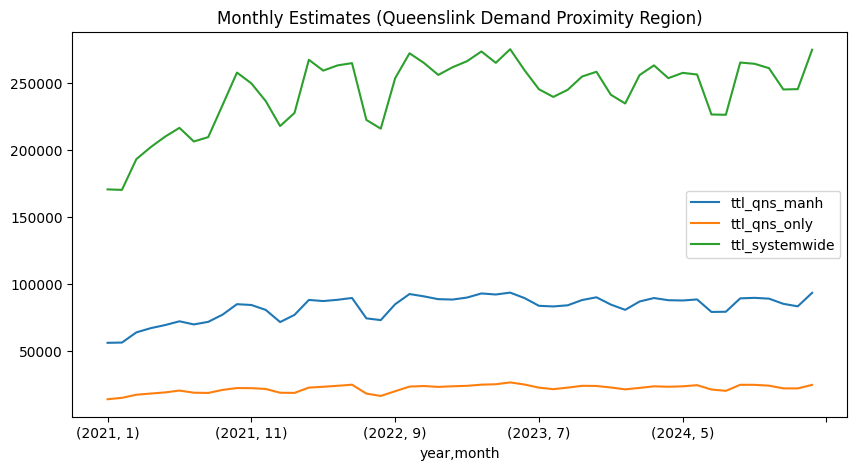

In [16]:
fig, ax = plt.subplots(3,1, figsize=(20,10))

combined_subway_ridership_analysis = combined_subway_ridership.reset_index()
combined_subway_ridership_analysis['dow'] = combined_subway_ridership_analysis['timestamp'].dt.day_of_week
combined_subway_ridership_analysis['hour'] = combined_subway_ridership_analysis['timestamp'].dt.hour 
combined_subway_ridership_analysis['month'] = combined_subway_ridership_analysis['timestamp'].dt.month 
combined_subway_ridership_analysis['year'] = combined_subway_ridership_analysis['timestamp'].dt.year

weekly_snapshot_example = combined_subway_ridership_analysis.groupby(['dow','hour']).mean()

weekly_snapshot_example[['outbound_ridership', 'inbound_ridership']].plot(ax=ax[0])
weekly_snapshot_example[['outbound_ridership_qns_only', 'inbound_ridership_qns_only']].plot(ax=ax[1]) 
weekly_snapshot_example[['outbound_ridership_qns_manh', 'inbound_ridership_qns_manh']].plot(ax=ax[2]) 
fig.suptitle('Inbound/Outbound Averaged Ridership Figures (Queenslink Demand Proximity Region)')

plt.show()

monthly = combined_subway_ridership_analysis.drop(columns=['timestamp']).groupby(['year','month']).sum()

monthly[['ttl_qns_manh','ttl_qns_only','ttl_systemwide']].plot(figsize=(10,5), title='Monthly Estimates (Queenslink Demand Proximity Region)')

plt.show()

In [5]:
weekly_snapshot_example

index                     timestamp  outbound_ridership  \
dow hour                                                                  
0   0     4090.080000 2023-01-19 18:43:12.000000000           52.585916   
    1     4174.551020 2023-02-04 00:59:59.999999744           32.486090   
    2     4343.276596 2023-03-06 09:08:56.170212864           37.238411   
    3     4176.510204 2023-02-04 03:00:00.000000256           79.255235   
    4     4093.980000 2023-01-19 22:43:12.000000000          327.555214   
...               ...                           ...                 ...   
6   19    4252.480000 2023-01-26 13:43:12.000000000          267.373782   
    20    4253.480000 2023-01-26 14:43:12.000000000          239.550922   
    21    4254.480000 2023-01-26 15:43:12.000000000          205.473132   
    22    4255.480000 2023-01-26 16:43:12.000000000          147.245450   
    23    4256.480000 2023-01-26 17:43:12.000000000           88.671320   

          inbound_ridership  outbound_ridership_qns_only  \
dow hour                                                   
0   0            150.797024                     5.676384   
    1             64.680565                     3.327029   
    2             45.041007                     3.063207   
    3             36.769988                     4.441060   
    4             84.967280                    19.639800   
...                     ...                          ...   
6   19           565.261958                    27.620956   
    20           470.004060                    23.144048   
    21           384.144930                    17.729864   
    22           339.539860                    12.659574   
    23           268.678964                     9.015974   

          inbound_ridership_qns_only  outbound_ridership_qns_manh  \
dow hour                                                            
0   0                      12.796440                    10.115522   
    1                       6.013006                     7.057953   
    2                       3.976176                    12.799013   
    3                       3.792825                    36.337310   
    4                       8.688870                   145.110154   
...                              ...                          ...   
6   19                     67.332624                    66.629766   
    20                     59.987848                    65.386778   
    21                     44.237480                    59.476766   
    22                     35.118856                    35.457088   
    23                     23.421282                    17.887994   

          inbound_ridership_qns_manh  ttl_qns_manh  ttl_qns_only  \
dow hour                                                           
0   0                      55.658380     65.773902     18.472824   
    1                      20.923208     27.981161      9.404140   
    2                      13.467022     26.538839      7.039383   
    3                       9.523485     46.591781      8.308296   
    4                      18.241044    163.351198     28.328670   
...                              ...           ...           ...   
6   19                    212.674412    279.304178     94.953580   
    20                    178.379898    243.766676     83.131896   
    21                    155.624838    215.101604     61.967344   
    22                    138.030368    173.487456     47.778430   
    23                    110.822148    128.710142     32.437256   

          ttl_systemwide     month         year  
dow hour                                         
0   0         203.382940  6.300000  2022.600000  
    1          97.166655  6.408163  2022.632653  
    2          83.072643  6.574468  2022.702128  
    3         116.025222  6.408163  2022.632653  
    4         412.522494  6.300000  2022.600000  
...                  ...       ...          ...  
6   19        832.635740  6.300000  2022.600000  
    20        709.554982  

#### Forecasting

In [21]:
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error
from pandas.tseries.offsets import DateOffset
import warnings 

warnings.filterwarnings('ignore')

def validate_model(subway_data, ridership_feat, get_monthly: bool):

    deliverables = dict()
    deliverables['prediction_var'] = ridership_feat
    f_only = subway_data[['timestamp', ridership_feat]]
    f_only['timestamp'] = pd.to_datetime(subway_data['timestamp'])
    f_only = f_only.set_index('timestamp')
    
    #trend feature
    f_only['t'] = f_only.index.astype(np.int64) // 10**10 

    #seasonal components
    f_only['month'] = [i.month for i in pd.to_datetime(f_only.index)]
    f_only['hr'] = [i.hour for i in pd.to_datetime(f_only.index)]
    f_only['dow'] = [i.day_of_week for i in pd.to_datetime(f_only.index)]


    #one-hot encode for tree-based models
    f_only_c = pd.concat(
        (
            f_only.drop(columns=['month','hr','dow']), 
            pd.get_dummies(f_only['month'], prefix='m'),
            pd.get_dummies(f_only['hr'], prefix='h'),
            pd.get_dummies(f_only['dow'], prefix='dow'),
        ),
        axis=1
    )

    #build training and validation sets
    f_only_c = f_only_c.reset_index()
    f_only_c[ridership_feat] = f_only_c[ridership_feat].bfill()
    train = f_only_c.loc[f_only_c['timestamp']<pd.to_datetime('2024-01-01')]
    validate = f_only_c.loc[f_only_c['timestamp']>pd.to_datetime('2024-01-01')]

    Xtrain, ytrain = train.iloc[:,2:], train[ridership_feat]
    Xvalid, yvalid = validate.iloc[:,2:], validate[ridership_feat]

    #do a grid search
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1, 0.2]
    }  

    #train model
    model = XGBRegressor()

   # model = Lasso()
   # param_grid = {
       # 'alpha' : [0,0.001,0.01,0.1,0.5] #uncomment this to run the baseline model...
  #  }
    model_cv = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

    model_cv.fit(Xtrain,ytrain)

    validate['predictions'] = model_cv.predict(Xvalid)
    mape = mean_absolute_percentage_error(yvalid,validate['predictions'])

    print(f'{ridership_feat} MAPE: {mape*100}%')

    if get_monthly:

        validate['date'] = validate['timestamp'].apply(lambda x: x.date())
        validate['month'] = validate['timestamp'].dt.month
        validate['year'] = validate['timestamp'].dt.year

        train['date'] = train['timestamp'].apply(lambda x: x.date())
        train['month'] = train['timestamp'].dt.month
        train['year'] = train['timestamp'].dt.year

        validation = validate.sort_values(by=['date']).groupby(['year','month'])[['predictions',ridership_feat]].sum()
        trained = train.sort_values(by=['date']).groupby(['year','month'])[[ridership_feat]].sum()

        deliverables['monthly_validation'] = validation
        deliverables['monthly_trained'] = trained


    deliverables['best_model'] = model_cv.best_estimator_
    deliverables['validation'] = validate 
    deliverables['trained'] = train

    return deliverables

def generate_forecast(validation_data, get_monthly: bool, retrain = True):
    
    st_forecast = validation_data['validation']['timestamp'].max()

    end_forecast = st_forecast + DateOffset(years=1)
    forecast_date_range = pd.date_range(start=st_forecast, end=end_forecast, freq='H')
    forecast = pd.DataFrame(forecast_date_range,columns=['timestamp'])
   
    forecast['t'] = forecast['timestamp'].astype(np.int64) // 10**10 

    #seasonal components
    forecast['month'] = forecast['timestamp'].dt.month
    forecast['hr'] = forecast['timestamp'].dt.hour
    forecast['dow'] = forecast['timestamp'].dt.day_of_week


    #one-hot encode for tree-based models
    f_only_c_fc = pd.concat(
        (
            forecast.drop(columns=['month','hr','dow']), 
            pd.get_dummies(forecast['month'], prefix='m'),
            pd.get_dummies(forecast['hr'], prefix='h'),
            pd.get_dummies(forecast['dow'], prefix='dow'),
        ),
        axis=1
    )

    first_week_monthly = f_only_c_fc.drop(columns=['timestamp','t']).drop_duplicates().index
    X_forecast = f_only_c_fc.iloc[first_week_monthly].set_index('timestamp')
    model = validation_data['best_model']
    if retrain:
        feats = validation_data['best_model'].get_booster().feature_names
        
        train = pd.concat((
            validation_data['trained'],validation_data['validation']
        ),
        axis=0
        )
        X, y = train[feats],train[validation_data['prediction_var']]
        model.fit(X,y)
        
    X_forecast['forecast'] = model.predict(X_forecast)
    forecast_only = X_forecast[['forecast']].reset_index()

    if get_monthly:
        forecast_only['timestamp_tr'] = forecast_only['timestamp'].dt.to_period('M')
        forecast_only_m = forecast_only.groupby(['timestamp_tr'])[['forecast']].sum()

        validation_data['monthly_forecast'] = forecast_only_m 
    validation_data['forecast'] = X_forecast
    return validation_data

def run_all(subway_data, ridership_feat):

    out_ttl = validate_model(
        subway_data = subway_data,
        ridership_feat= ridership_feat,
        get_monthly = True
    )
    out_ttl = generate_forecast(
        validation_data=out_ttl, 
        get_monthly=True,
    )

    return out_ttl

feats = [
    'ttl_systemwide','ttl_qns_manh','ttl_qns_only'
]

output_data = dict()
for feat in feats: 
    output_data[feat] = run_all(combined_subway_ridership, feat)


ttl_systemwide MAPE: 10.912022164106961%
ttl_qns_manh MAPE: 11.900237921660118%
ttl_qns_only MAPE: 14.947267656311375%


In [23]:
output_data_monthly_forecast_all = pd.concat(
    [output_data[f]['monthly_forecast'].rename(columns={'forecast':f'forecast_{f}'}) for f in feats],axis=1
)

output_data_monthly_forecast_all

,forecast_ttl_systemwide,forecast_ttl_qns_manh,forecast_ttl_qns_only
timestamp_tr,,,
2025-02,266687.187500,91159.250000,25137.867188
2025-03,269292.000000,92300.437500,25258.669922
2025-04,265767.000000,91529.265625,25461.613281
2025-05,267586.625000,90912.257812,24628.353516
2025-06,267339.500000,92661.351562,25971.033203
2025-07,240325.578125,84500.406250,23607.322266
2025-08,241784.828125,86181.789062,22800.535156
2025-09,265859.062500,91005.421875,25689.392578
2025-10,267930.156250,91592.382812,25130.607422


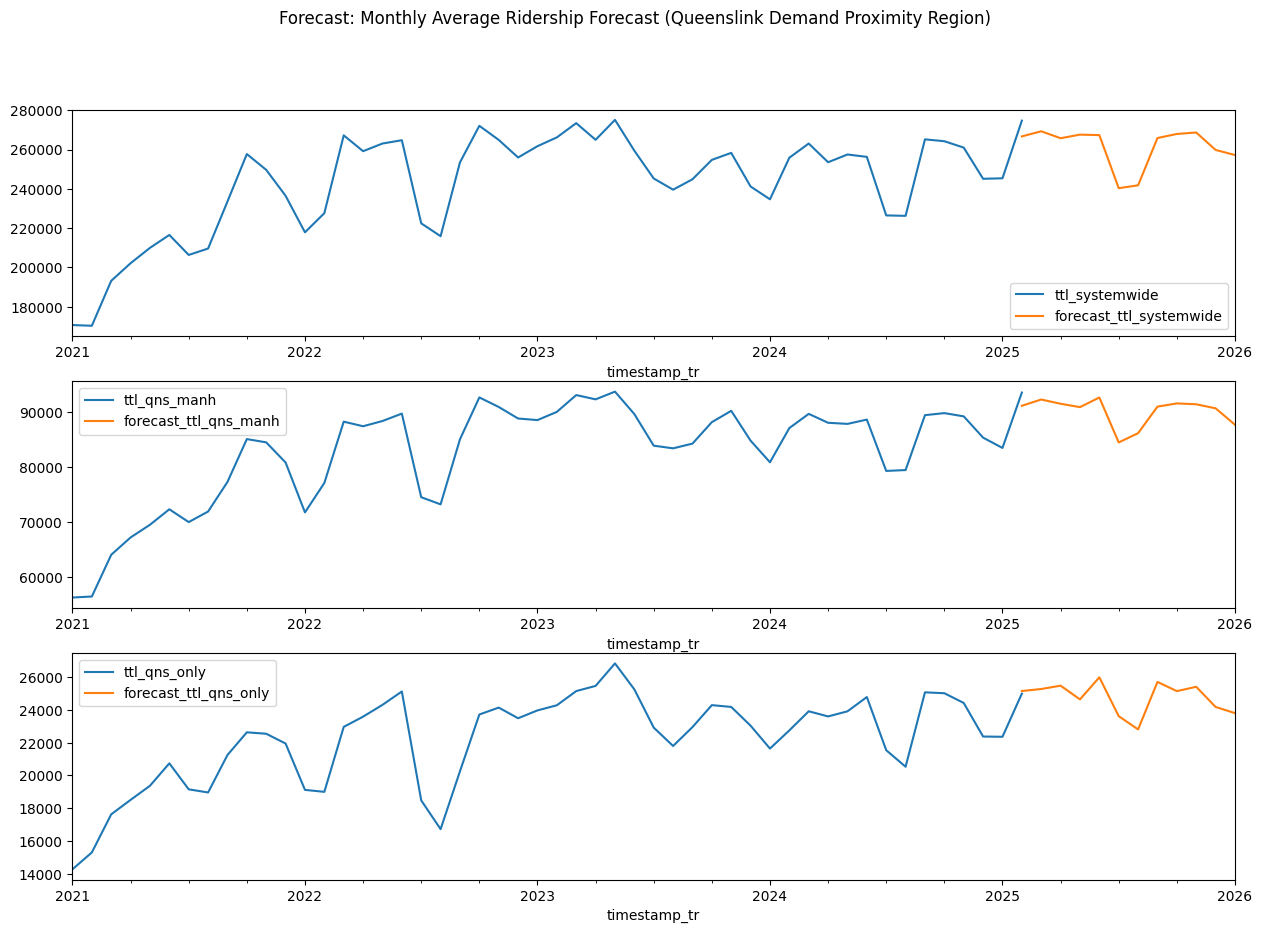

In [24]:
monthly_gt = monthly.reset_index()

monthly_gt['timestamp_tr'] = pd.to_datetime(monthly_gt['year'].astype(str) + '-' + monthly_gt['month'].astype(str)).dt.to_period('M')
monthly_gt = monthly_gt.set_index('timestamp_tr')[['ttl_systemwide','ttl_qns_manh', 'ttl_qns_only']]

gt_w_forecast_monthly = pd.concat((monthly_gt,output_data_monthly_forecast_all))

fig,ax=plt.subplots(3,1,figsize=(15,10))
for idx,feat in enumerate(feats):
    gt_w_forecast_monthly[[feat,f'forecast_{feat}']].plot(ax=ax[idx])

fig.suptitle('Forecast: Monthly Average Ridership Forecast (Queenslink Demand Proximity Region)')
plt.show()

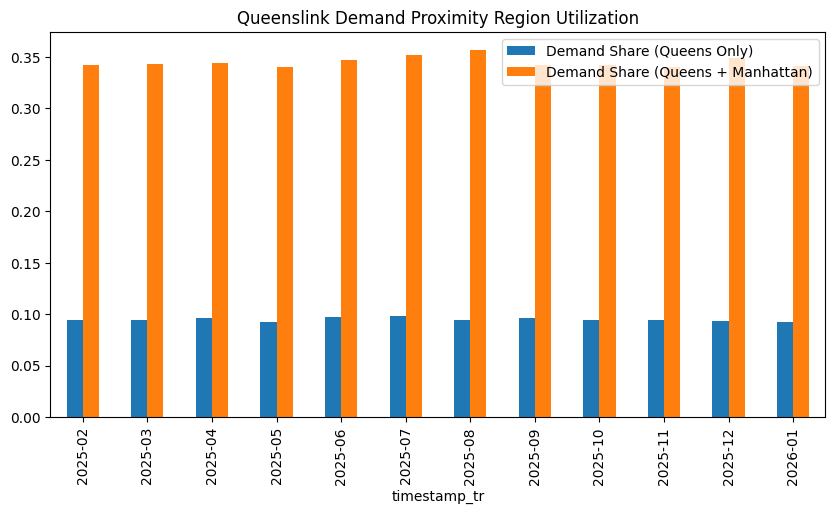

In [142]:
output_data_monthly_forecast_all['Demand Share (Queens Only)'] = output_data_monthly_forecast_all['forecast_ttl_qns_only']/output_data_monthly_forecast_all['forecast_ttl_systemwide']
output_data_monthly_forecast_all['Demand Share (Queens + Manhattan)'] = output_data_monthly_forecast_all['forecast_ttl_qns_manh']/output_data_monthly_forecast_all['forecast_ttl_systemwide']

output_data_monthly_forecast_all[['Demand Share (Queens Only)','Demand Share (Queens + Manhattan)']].plot(
    kind='bar', 
    figsize=(10,5), 
    title='Queenslink Demand Proximity Region Utilization'
)
plt.show()

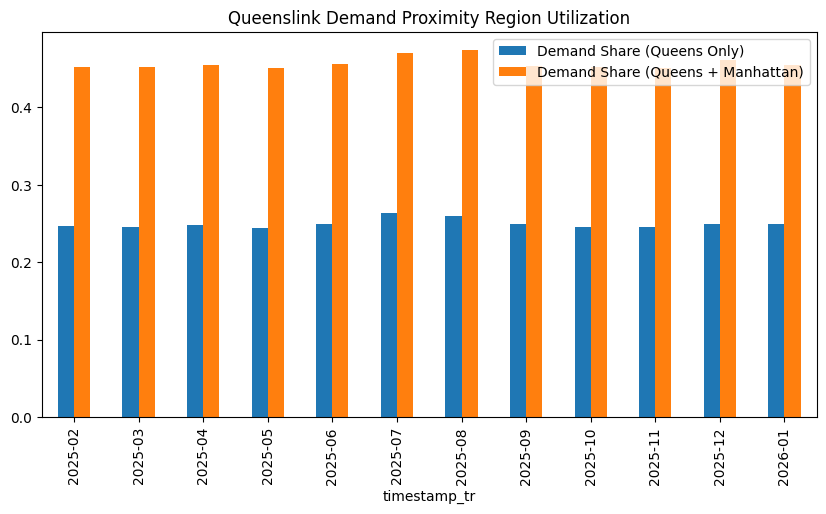

In [26]:
lift_bus_demand = 54000 #look at tim's nb

output_data_monthly_forecast_all['Demand Share (Queens Only)'] = (output_data_monthly_forecast_all['forecast_ttl_qns_only']+lift_bus_demand)/(output_data_monthly_forecast_all['forecast_ttl_systemwide']+lift_bus_demand)
output_data_monthly_forecast_all['Demand Share (Queens + Manhattan)'] = (output_data_monthly_forecast_all['forecast_ttl_qns_manh']+lift_bus_demand)/(output_data_monthly_forecast_all['forecast_ttl_systemwide']+lift_bus_demand)

output_data_monthly_forecast_all[['Demand Share (Queens Only)','Demand Share (Queens + Manhattan)']].plot(
    kind='bar', 
    figsize=(10,5), 
    title='Queenslink Demand Proximity Region Utilization'
)
plt.show()

In [27]:
output_data_monthly_forecast_all

,forecast_ttl_systemwide,forecast_ttl_qns_manh,forecast_ttl_qns_only,Demand Share (Queens Only),Demand Share (Queens + Manhattan)
timestamp_tr,,,,,
2025-02,266687.187500,91159.250000,25137.867188,0.246776,0.452651
2025-03,269292.000000,92300.437500,25258.669922,0.245161,0.452533
2025-04,265767.000000,91529.265625,25461.613281,0.248498,0.455110
2025-05,267586.625000,90912.257812,24628.353516,0.244501,0.450617
2025-06,267339.500000,92661.351562,25971.033203,0.248868,0.456406
2025-07,240325.578125,84500.406250,23607.322266,0.263678,0.470569
2025-08,241784.828125,86181.789062,22800.535156,0.259650,0.473932
2025-09,265859.062500,91005.421875,25689.392578,0.249139,0.453342
2025-10,267930.156250,91592.382812,25130.607422,0.245801,0.452248
